### **Text Summarization on generalized data**

In [1]:
!pip install --upgrade --no-cache-dir transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 197.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


In [3]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ea86a8fd580e2891d14736c98a9093653f7773ec634017c8679aa73868bb863b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [4]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00


#### **TRAINING**

In [1]:
# Hugging Face Transformers
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration


# Loading datasets
dataset = load_dataset("csv", data_files="../datasets/sample/gemini_generalization_dataset_sample.csv", sep=',', split='train')
print(dataset.column_names)

dataset = dataset.map(lambda x: {"full_note": x["full_note"], "summary": x["anonym_note"]})
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset_split["train"]
test_data = dataset_split["test"]

# Tokenization
tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess(example):
    inputs = tokenizer(example["full_note"], truncation=True, padding="max_length", max_length=4096)
    targets = tokenizer(example["summary"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

C:\Users\rafau\Documents\PythonProjects\DataSanitization\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['index', 'note', 'anonym_note', 'sensitive_entity_note', 'full_note']


In [8]:
# Training Arguments
from transformers import LongformerForSequenceClassification
model_clear = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384")

# Enable gradient checkpointing on the model
model_clear.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="./results_generalization_summary",        # folder for checkpoints
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,                        # effectively larger batch size
    fp16=True,                                            # mixed precision training
    save_strategy="epoch",                                # save checkpoint at every epoch
    num_train_epochs=2,

    # Logging
    logging_dir="./logs",
    logging_steps=50,                                     # more frequent logging
    report_to=["tensorboard","wandb"],                    # log to TensorBoard and W&B

    # Learning rate and optimization
    learning_rate=2e-5,                                   # more stable LR for small batches
    weight_decay=0.01,                                    # regularization
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    lr_scheduler_type="linear",
    warmup_steps=100                                      # warmup during first steps
)

In [9]:
# Trainer
trainer = Trainer(
    model=model_clear,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raffaeleaurucci (raffaeleaurucci-universit-degli-studi-di-salerno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,6.755200
100,3.292900
150,1.890700
200,1.194200
250,0.933000
300,0.821000
350,0.796900
400,0.762000
450,0.782300
500,0.771000


TrainOutput(global_step=500, training_loss=1.7999224243164063, metrics={'train_runtime': 8925.1961, 'train_samples_per_second': 0.896, 'train_steps_per_second': 0.056, 'total_flos': 2.1601638678528e+16, 'train_loss': 1.7999224243164063, 'epoch': 2.0})

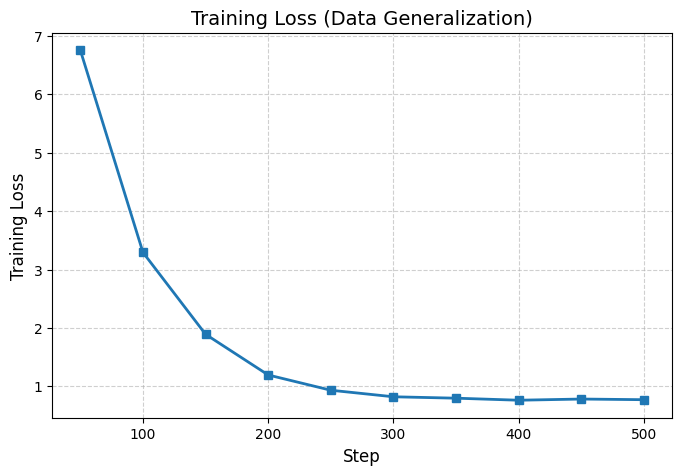

In [4]:
import matplotlib.pyplot as plt

# Data
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
train_losses = [6.7552, 3.2929, 1.8907, 1.1942, 0.9330, 0.8210, 0.7969, 0.7620, 0.7823, 0.7710]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, marker='s', linestyle='-', linewidth=2, markersize=6)

# Label and title
plt.title("Training Loss (Data Generalization)", fontsize=14)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

In [10]:
!zip -r results_generalization_summary.zip results_generalization_summary/checkpoint-500/

  adding: results_generalization_summary/checkpoint-500/ (stored 0%)
  adding: results_generalization_summary/checkpoint-500/trainer_state.json (deflated 70%)
  adding: results_generalization_summary/checkpoint-500/optimizer.pt (deflated 14%)
  adding: results_generalization_summary/checkpoint-500/config.json (deflated 60%)
  adding: results_generalization_summary/checkpoint-500/scheduler.pt (deflated 62%)
  adding: results_generalization_summary/checkpoint-500/generation_config.json (deflated 33%)
  adding: results_generalization_summary/checkpoint-500/model.safetensors (deflated 11%)
  adding: results_generalization_summary/checkpoint-500/scaler.pt (deflated 64%)
  adding: results_generalization_summary/checkpoint-500/rng_state.pth (deflated 26%)
  adding: results_generalization_summary/checkpoint-500/training_args.bin (deflated 53%)


In [11]:
from google.colab import files

# Download file CSV
files.download("results_generalization_summary.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

for step, loss in enumerate(losses, 1):
    print(f"Step {step} - Training Loss: {loss}")

Step 1 - Training Loss: 6.7552
Step 2 - Training Loss: 3.2929
Step 3 - Training Loss: 1.8907
Step 4 - Training Loss: 1.1942
Step 5 - Training Loss: 0.933
Step 6 - Training Loss: 0.821
Step 7 - Training Loss: 0.7969
Step 8 - Training Loss: 0.762
Step 9 - Training Loss: 0.7823
Step 10 - Training Loss: 0.771


In [8]:
from transformers import pipeline, logging
from tqdm import tqdm

# Disable warnings
logging.set_verbosity_error()

# Disable gradient checkpointing
model_clear.gradient_checkpointing_disable()

# Summarization pipeline
summarizer_clear = pipeline("summarization", model=model_clear, tokenizer=tokenizer, device=0)

# Test set
test_texts = [ex["full_note"] for ex in test_data]

# List to store the generated summaries
generated_summaries = []

# Progress bar with tqdm
for text in tqdm(test_texts, desc="Generating summary"):
    summary = summarizer_clear(
        text,
        max_length=512,
        min_length=400,
        truncation=True
    )[0]["summary_text"]
    generated_summaries.append(summary)

# Number of inferences
num_inferenze = len(generated_summaries)
print(f"Number of inferences: {num_inferenze}")

# Reference summaries
references = [ex["summary"] for ex in test_data]

Generating summary:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1636: UserWarning: Unfeasible length constraints: `min_length` (400) is larger than the maximum possible length (257). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Generating summary: 100%|██████████| 1000/1000 [41:15<00:00,  2.48s/it]


Number of inferences: 1000


In [9]:
generated_summaries[0]

"The patient was an adult who presented with a swelling of the posterior surface of the left leg. The patient's prior history included a prolonged stay in hospital for treatment of a bacterial infection, which was performed. The patient had also previously undergone multiple surgical procedures to treat an intestinal tumor and varicose veins surgery. Physical examination revealed a pulsating mass in the posterior region of the left leg. Femoral, popliteal, and dorsal pedal pulses were palpable and normal in both lower limbs. The posterior tibial artery pulse was absent, whereas the posterior tibial artery pulse was palpable in the right lower limb. Magnetic resonance angiography showed a saccular dilatation in the tibioperoneal trunk with a large diameter, at the level of the origin of the posterior tibial artery. The posterior tibial artery was also occluded. Investigation was supplemented with laboratory tests, which all returned normal results, in addition to blood cultures, which w

In [15]:
# Evaluations
import evaluate

# ROUGE
rouge = evaluate.load("rouge")

results_clear = rouge.compute(predictions=generated_summaries, references=references)
print("ROUGE - Model on randomized data:")
for k, v in results_clear.items():
    print(f"{k}: {v:.4f}")

ROUGE - Model on randomized data:
rouge1: 0.5687
rouge2: 0.3418
rougeL: 0.4565
rougeLsum: 0.4566


In [16]:
# BLEU
bleu = evaluate.load("bleu")

references_bleu = [[ref] for ref in references]

results_bleu = bleu.compute(predictions=generated_summaries, references=references_bleu)

print(f"BLEU score: {results_bleu['bleu']:.4f}")

BLEU score: 0.2960


In [17]:
from bert_score import score

# BERTScore
P, R, F1 = score(generated_summaries, references, lang="en", verbose=True)

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 87.90 seconds, 11.38 sentences/sec
Precision: 0.8973
Recall: 0.8938
F1: 0.8954


In [10]:
import csv
from google.colab import files

with open("summaries_generalization.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["full_note", "summary"])
    for full_note, summary in zip(test_texts, generated_summaries):
        writer.writerow([full_note, summary])

# Download file CSV
files.download("summaries_generalization.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
from statistics import mean

texts = [ex["summary"] for ex in train_data]
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]
avg_tokens = mean(token_lengths)

print(f"Average token per entry in train set: {avg_tokens:.2f}")

Average token per entry in train set: 307.49


In [3]:
from statistics import mean

texts = [ex["full_note"] for ex in train_data]
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]
max_token_length = max(token_lengths)
avg_tokens = mean(token_lengths)

print(f"Average token per entry in train set: {avg_tokens:.2f}")
print(f"Max token per entry in train set: {max_token_length:.2f}")

print(len([token for token in token_lengths if token > 4096]))

Average token per entry in train set: 739.61
Max token per entry in train set: 5454.00
2
